In [1]:
import typing
import math

import pandas as pd
import numpy as np
import seaborn as sns
import shapely.affinity
import shapely.geometry
import shapely.ops
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

current_palette = sns.color_palette()
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

sns.set(rc={'figure.figsize':(10,4)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
islands = pd.read_csv("islands.csv")
buoys = pd.read_csv("stations.csv")

buoys["IS_BUOY"] =  buoys["TTYPE"].apply(lambda x: type(x) == str and "BUOY" in x.upper() and not "DRIFT" in x.upper())

ships = pd.read_csv("ships.csv")
ships.rename(columns={"LON": "LONGITUDE", "LAT": "LATITUDE"}, inplace=True)

# only care about ships out at sea
ships = ships[ships["SHIPNAME"] == "[SAT-AIS]"]

In [4]:
pacific_borders = pd.read_csv("./pacific.csv")
# antimeridian (dateline) shenanigans
pacific_polygon = shapely.geometry.Polygon(pacific_borders.values)
pacific_polygon2 = shapely.affinity.translate(pacific_polygon, xoff = 360)

In [5]:
# filter for pacific
islands["IN_PACIFIC"] = islands.apply(lambda x: shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon) or shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon2), axis=1)
ships["IN_PACIFIC"] = ships.apply(lambda x: shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon) or shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon2), axis=1)
buoys["IN_PACIFIC"] = buoys.apply(lambda x: shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon) or  shapely.geometry.Point(x["LONGITUDE"], x["LATITUDE"]).within(pacific_polygon2), axis=1)

In [6]:
buoys = buoys[(buoys["IN_PACIFIC"] == True) & (buoys["IS_BUOY"] == True)]
buoys.reset_index(inplace=True, drop=True)

islands = islands[(islands["IN_PACIFIC"] == True)]
islands.reset_index(inplace=True, drop=True)
islands["STATION_ID"] = ["ISLAND" + str(i) for i in range(len(islands))]

ships = ships[(ships["IN_PACIFIC"] == True)]
ships.reset_index(inplace=True, drop=True)
ships["STATION_ID"] = ["SHIP" + str(i) for i in range(len(ships))]

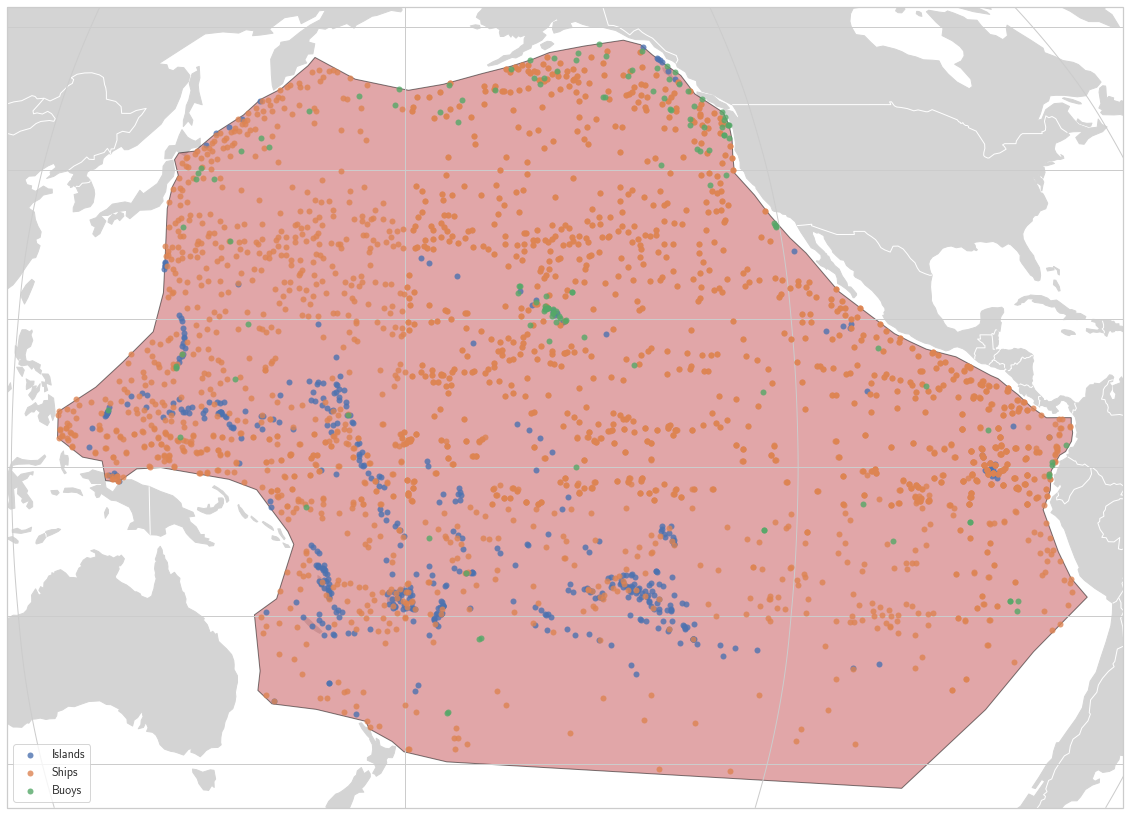

In [7]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=islands, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)
sns.scatterplot(ax=ax, data=ships, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)
sns.scatterplot(ax=ax, data=buoys, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)
ax.add_geometries([pacific_polygon], crs=ccrs.PlateCarree(), facecolor = 'r', edgecolor='black', alpha=0.5)
ax.legend(["Islands", "Ships", "Buoys"], loc="lower left", fontsize=12)

plt.show()

In [8]:
# two buoys are in the same group if they have the same owner and the distance between them is less than 100 km
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

group_id = 1

done = False

buoys["SENSOR_ID"] = range(len(buoys))
buoys["GROUP"] = buoys["SENSOR_ID"]

while not done:
    done = True

    for b1 in range(0,buoys.shape[0]):
        for b2 in range(b1,buoys.shape[0]):
            if b1 != b2:
                if (buoys["OWNER"][b1] == buoys["OWNER"][b2]) and (haversine(buoys["LATITUDE"][b1], buoys["LONGITUDE"][b1], buoys["LATITUDE"][b2], buoys["LONGITUDE"][b2]) < 1000):

                    if buoys["GROUP"][b2] != buoys["GROUP"][b1]:
                        b1_group = buoys["GROUP"][b1]
                        b2_group = buoys["GROUP"][b2]
                        new_group = min(b1_group, b2_group)
                        buoys[(buoys["GROUP"] == b1_group) | (buoys["GROUP"] == b2_group)]["GROUP"] = new_group
                        for b in range(0,buoys.shape[0]):
                            if buoys["GROUP"][b] == b1_group or buoys["GROUP"][b] == b2_group:
                                buoys["GROUP"][b] = new_group
                        done = False


buoys["SENSOR_ID"] = buoys["SENSOR_ID"].astype(int).astype(str)
buoys["GROUP"] = buoys["GROUP"].astype(int).astype(str)

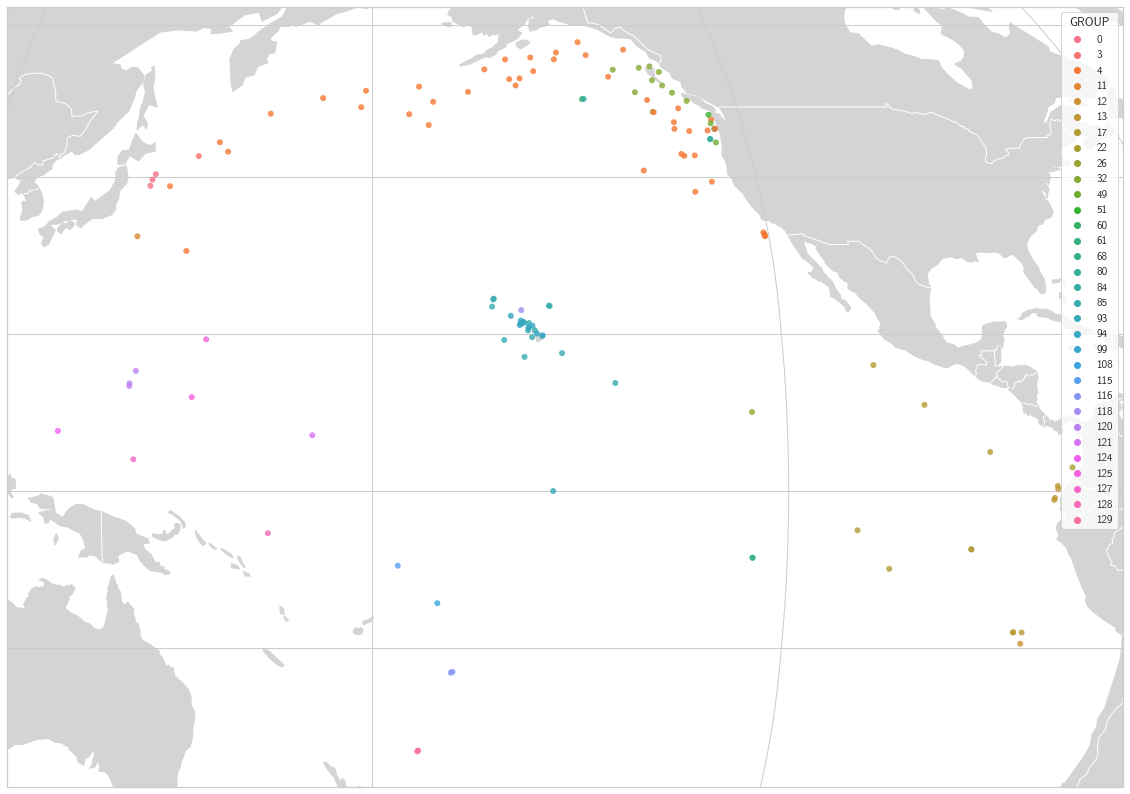

In [9]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=buoys, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8, hue="GROUP")

plt.show()

In [10]:
buoys = buoys[["SENSOR_ID", "GROUP", "LATITUDE", "LONGITUDE"]]

In [11]:
buoys

,SENSOR_ID,GROUP,LATITUDE,LONGITUDE
0,0,0,40.302,146.192
1,1,0,39.601,145.799
2,2,0,38.816,145.595
3,3,3,42.617,152.583
4,4,4,30.517,152.127
...,...,...,...,...
128,128,128,-5.373,164.990
129,129,129,-33.109,-173.155
130,130,129,-33.005,-172.985
131,131,4,55.300,-157.000


In [12]:
buoys_to_use = buoys.sample(n=50, random_state=0)
buoys_to_use.reset_index(drop=True, inplace=True)
buoys_to_use.head()

,SENSOR_ID,GROUP,LATITUDE,LONGITUDE
0,94,94,19.734,-155.082
1,130,129,-33.005,-172.985
2,26,26,10.051,-125.032
3,8,4,43.192,157.142
4,30,4,42.658,-130.502


In [13]:
# find out island to group affinity
ships["SINK_TYPE"] = "SHIP"
islands["SINK_TYPE"] = "ISLAND"
sinks = pd.concat([islands, ships])
sinks.reset_index(inplace=True)
sink_affinity = pd.DataFrame()

for s in range(0,sinks.shape[0]):
    for b in range(0, buoys_to_use.shape[0]):
        if haversine(sinks["LONGITUDE"][s], sinks["LATITUDE"][s], buoys_to_use["LONGITUDE"][b], buoys_to_use["LATITUDE"][b]) < 2000:
            sink_affinity = sink_affinity.append({"STATION_ID": sinks["STATION_ID"][s], "GROUP": buoys_to_use["GROUP"][b]}, ignore_index=True)

In [14]:
# remove sinks with no affinity
sinks.drop(sinks[sinks["STATION_ID"].isin(sink_affinity["STATION_ID"]) == False].index, inplace=True)

In [15]:
sink_affinity.drop_duplicates(inplace=True)
sink_affinity.reset_index(drop=True, inplace=True)
sink_affinity

,STATION_ID,GROUP
0,ISLAND1,129
1,ISLAND2,129
2,ISLAND3,125
3,ISLAND14,129
4,ISLAND14,116
...,...,...
6358,SHIP2908,13
6359,SHIP2909,22
6360,SHIP2909,13
6361,SHIP2910,22


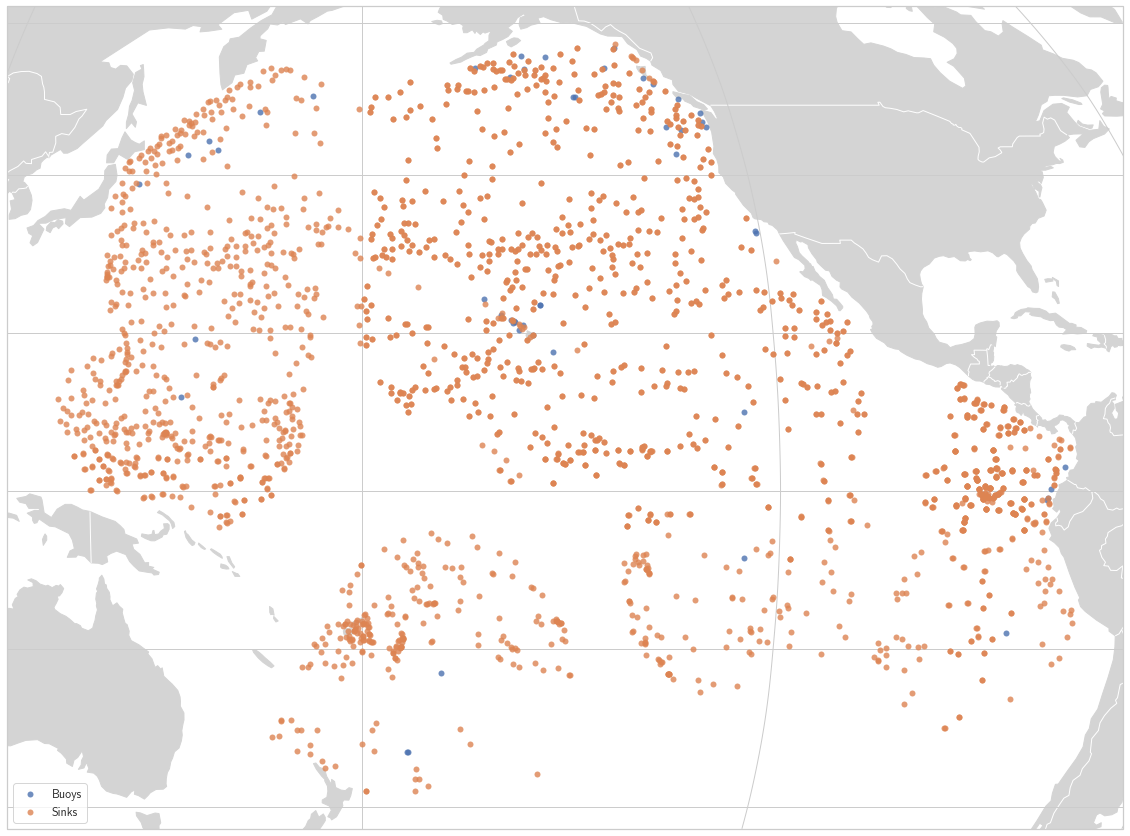

In [16]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=buoys_to_use, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)
sns.scatterplot(ax=ax, data=sinks, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)
ax.legend(["Buoys", "Sinks"], loc="lower left", fontsize=12)

plt.show()

In [17]:
sinks_to_use = sinks.sample(n=150, random_state=0)
sinks_to_use.reset_index(inplace=True)
sinks_to_use = sinks_to_use[["STATION_ID", "LONGITUDE", "LATITUDE"]]
sinks_to_use.head()

,STATION_ID,LONGITUDE,LATITUDE
0,SHIP1380,-155.26810,15.428320
1,SHIP1603,143.99330,1.620000
2,SHIP2110,-85.32836,1.105467
3,ISLAND149,150.00000,8.780000
4,SHIP1696,169.15190,49.981030


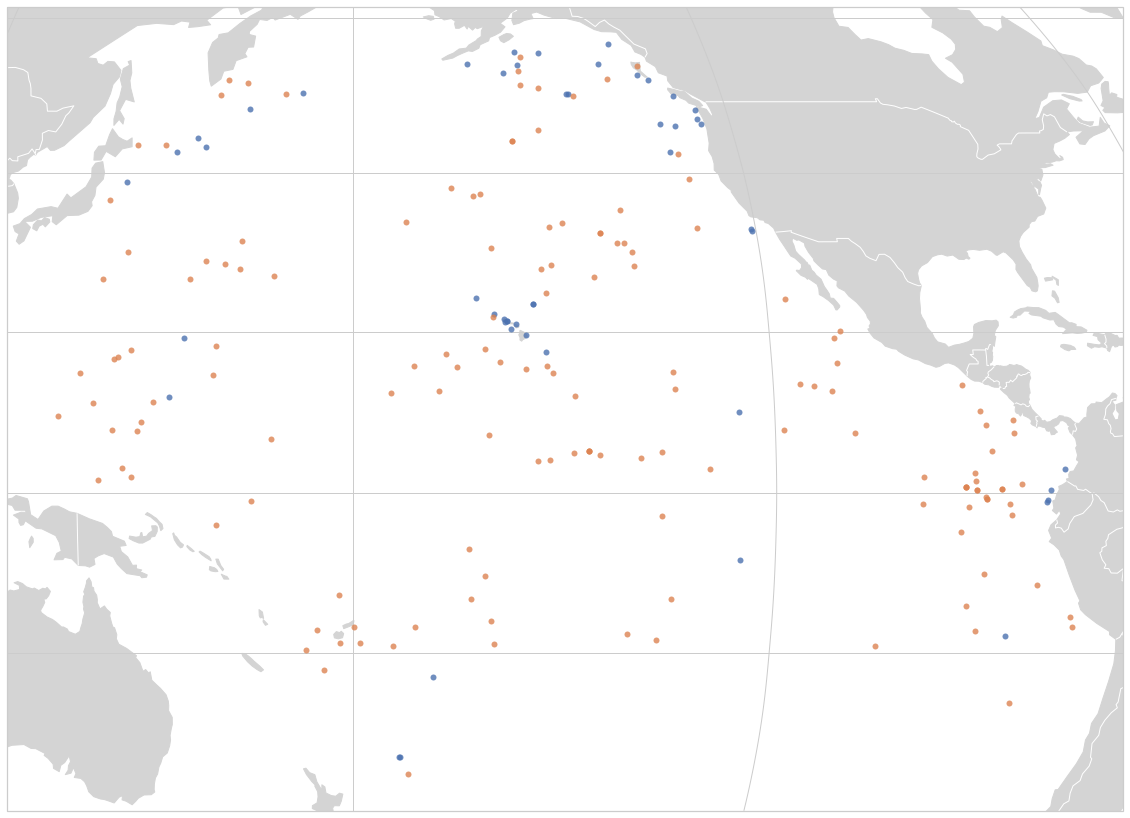

In [18]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=buoys_to_use, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)

sns.scatterplot(ax=ax, data=sinks_to_use, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=0, alpha=0.8)

plt.show()

In [19]:
# create affinity.csv and groups.csv
sink_affinity[sink_affinity["STATION_ID"].isin(sinks_to_use.index)].to_csv("affinity.csv", index=False)

buoys_to_use["GROUP"].to_csv("groups.csv", index=True)

In [20]:
# join buoy, ship, and island dataframes to get list of all locations and add a column for type of location
buoys_to_use["LOCATION_TYPE"] = "BUOY"
sinks_to_use["LOCATION_TYPE"] = "SINK"
all_locations = pd.concat([buoys_to_use, sinks_to_use])
all_locations.reset_index(drop=True, inplace=True)

all_locations.head()

,SENSOR_ID,GROUP,LATITUDE,LONGITUDE,LOCATION_TYPE,STATION_ID
0,94,94,19.734,-155.082,BUOY,NaN
1,130,129,-33.005,-172.985,BUOY,NaN
2,26,26,10.051,-125.032,BUOY,NaN
3,8,4,43.192,157.142,BUOY,NaN
4,30,4,42.658,-130.502,BUOY,NaN


In [21]:
# generate toml
with open("locations.csv", "w") as c_f:
    c_f.write("id,type,lat,lng\n")
    with open("locations.toml", "w") as f:
        for index, row in all_locations.iterrows():
            if row["LOCATION_TYPE"] == "BUOY":
                c_f.write(f"{row.index},sensor,{row['LATITUDE']},{row['LONGITUDE']}\n")

                f.write(f"""
[[groundstation]]
name = "sensor{row['SENSOR_ID']}"
lat = {row['LATITUDE']}
long = {row['LONGITUDE']}

[groundstation.computeparams]
rootfs = "sensor.img"

""")

                continue
            else:
                c_f.write(f"{row.index},sink,{row['LATITUDE']},{row['LONGITUDE']}\n")
                f.write(f"""
[[groundstation]]
name = "sink{row['STATION_ID']}"
lat = {row['LATITUDE']}
long = {row['LONGITUDE']}

[groundstation.computeparams]
rootfs = "sink.img"

""")

                continue

In [22]:
sinks_to_use.head()

,STATION_ID,LONGITUDE,LATITUDE,LOCATION_TYPE
0,SHIP1380,-155.26810,15.428320,SINK
1,SHIP1603,143.99330,1.620000,SINK
2,SHIP2110,-85.32836,1.105467,SINK
3,ISLAND149,150.00000,8.780000,SINK
4,SHIP1696,169.15190,49.981030,SINK


In [24]:
grouped_locations = sinks_to_use.merge(sink_affinity, on="STATION_ID", how="inner")
grouped_locations.head()

,STATION_ID,LONGITUDE,LATITUDE,LOCATION_TYPE,GROUP
0,SHIP1380,-155.26810,15.428320,SINK,94
1,SHIP1380,-155.26810,15.428320,SINK,85
2,SHIP1603,143.99330,1.620000,SINK,125
3,SHIP2110,-85.32836,1.105467,SINK,22
4,SHIP2110,-85.32836,1.105467,SINK,13


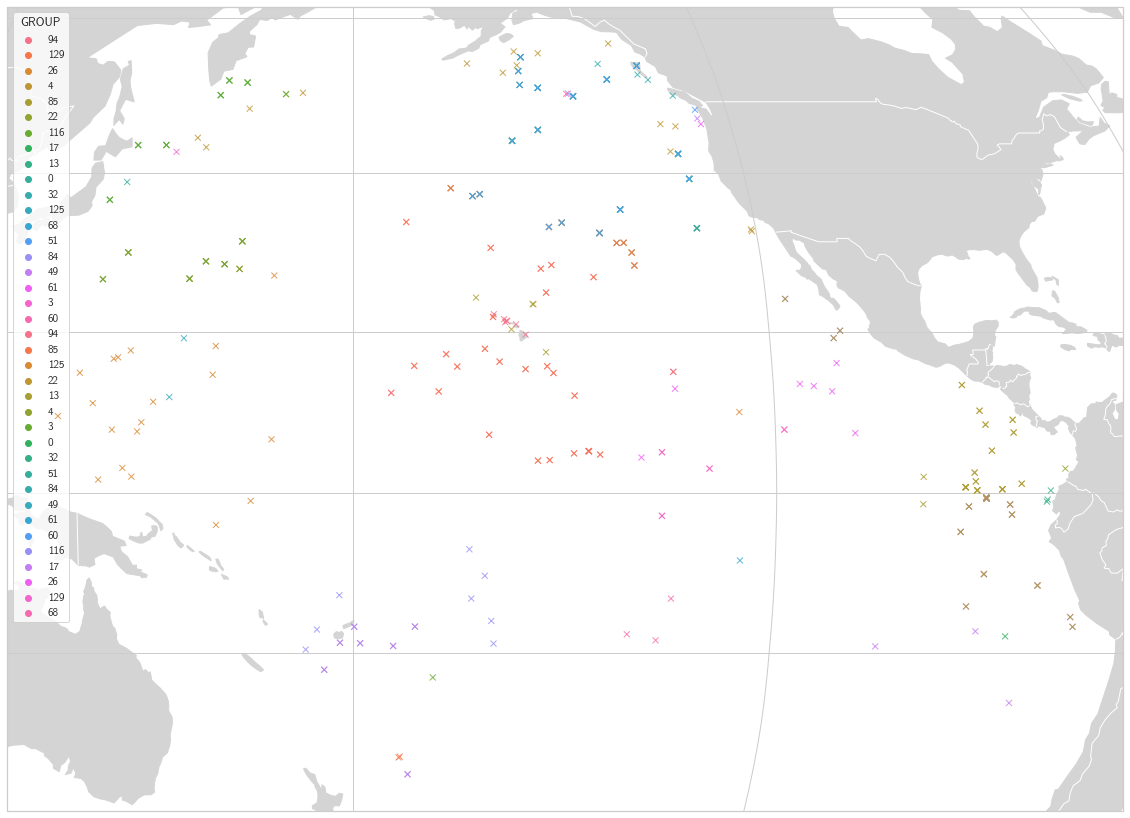

In [41]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=buoys_to_use, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=1, alpha=0.8, hue="GROUP", marker="x")
sns.scatterplot(ax=ax, data=grouped_locations, x="LONGITUDE", y="LATITUDE", transform=ccrs.PlateCarree(), zorder=10, linewidth=1, alpha=0.8, hue="GROUP", marker="x")

plt.show()

In [25]:
EARTH_RADIUS = 6371000
def sat_dist(altitude: float, elevation: float) -> float:
    A = EARTH_RADIUS
    B = EARTH_RADIUS + altitude * 1000
    b = np.radians(90.0 + elevation)
    a = np.arcsin(A * np.sin(b) / B)
    c = np.radians(180) - a - b

    return float(2.0 * np.pi * EARTH_RADIUS * c/np.radians(360.0))

# max sat distance in iridium:
max_dist = sat_dist(altitude=780, elevation=8.2)

In [26]:
# old bbox
l_lat = pacific_borders.min()["LATITUDE"]
l_lng = pacific_borders.min()["LONGITUDE"]
r_lat = pacific_borders.max()["LATITUDE"]
r_lng = pacific_borders.max()["LONGITUDE"]

# offset latitudes by max distance
# https://stackoverflow.com/questions/2839533/adding-distance-to-a-gps-coordinate

l_lat_new = l_lat - (180/np.pi)*(max_dist/EARTH_RADIUS)
l_lng_new = l_lng - (180/np.pi)*(max_dist/EARTH_RADIUS) * np.cos(np.radians(l_lat))
r_lat_new = r_lat + (180/np.pi)*(max_dist/EARTH_RADIUS)
r_lng_new = r_lng + (180/np.pi)*(max_dist/EARTH_RADIUS) * np.cos(np.radians(r_lat))

bbox_polygon = shapely.geometry.Polygon([[l_lng, l_lat], [l_lng, r_lat], [r_lng, r_lat], [r_lng, l_lat]])
bbox_polygon_new = shapely.geometry.Polygon([[l_lng_new, l_lat_new], [l_lng_new, r_lat_new], [r_lng_new, r_lat_new], [r_lng_new, l_lat_new]])

print(f"""
old bbox:
l_lat: {l_lat}
l_lng: {l_lng}
r_lat: {r_lat}
r_lng: {r_lng}

new bbox:
l_lat: {l_lat_new}
l_lng: {l_lng_new}
r_lat: {r_lat_new}
r_lng: {r_lng_new}
""")


old bbox:
l_lat: -43.259706
l_lng: -233.0859375
r_lat: 58.2021939
r_lng: -74.5388889

new bbox:
l_lat: -63.19752906550502
l_lng: -247.6057546094728
r_lat: 78.14001696550503
r_lng: -64.03318633137593



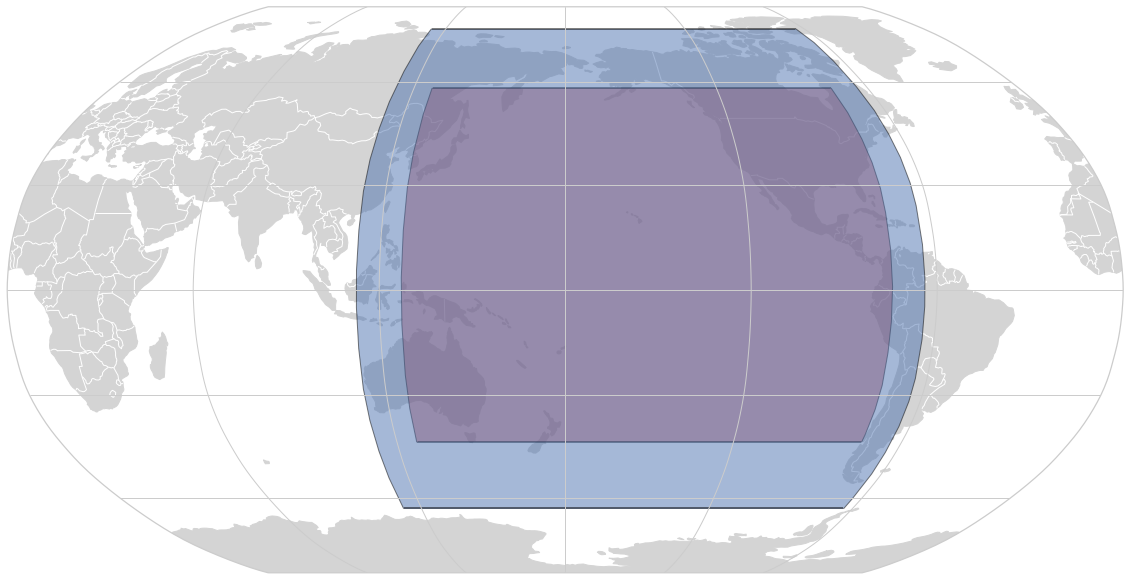

In [27]:
cmap = sns.color_palette("viridis", as_cmap=True)

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()
ax.add_geometries([bbox_polygon], crs=ccrs.PlateCarree(), facecolor = 'r', edgecolor='black', alpha=0.5)
ax.add_geometries([bbox_polygon_new], crs=ccrs.PlateCarree(), facecolor = 'b', edgecolor='black', alpha=0.5)
plt.show()

In [28]:
# bounding box
print(f'[{l_lat_new}, {l_lng_new + 360}, {r_lat_new}, {r_lng_new}]')

[-63.19752906550502, 112.3942453905272, 78.14001696550503, -64.03318633137593]


In [29]:
all_locations.head()

,SENSOR_ID,GROUP,LATITUDE,LONGITUDE,LOCATION_TYPE,STATION_ID
0,94,94,19.734,-155.082,BUOY,NaN
1,130,129,-33.005,-172.985,BUOY,NaN
2,26,26,10.051,-125.032,BUOY,NaN
3,8,4,43.192,157.142,BUOY,NaN
4,30,4,42.658,-130.502,BUOY,NaN


In [30]:
bbox = {
    "lon1": l_lng_new + 360,
    "lat1": l_lat_new,
    "lon2": r_lng_new,
    "lat2": r_lat_new
}

def is_in_bbox(lon: float, lat:float) -> bool:

    # check if lat long is in bounding box
    if bbox["lon2"] < bbox["lon1"]:
        if lon < bbox["lon1"] and lon > bbox["lon2"]:
            return False
    else:
        if lon < bbox["lon1"] or lon > bbox["lon2"]:
            return False

    return bool(lat >= bbox["lat1"] and lat <= bbox["lat2"])

all_locations["IN_BBOX"] = all_locations.apply(lambda row: is_in_bbox(row["LONGITUDE"], row["LATITUDE"]), axis=1)

In [31]:
len(all_locations[all_locations["IN_BBOX"] == False])

0

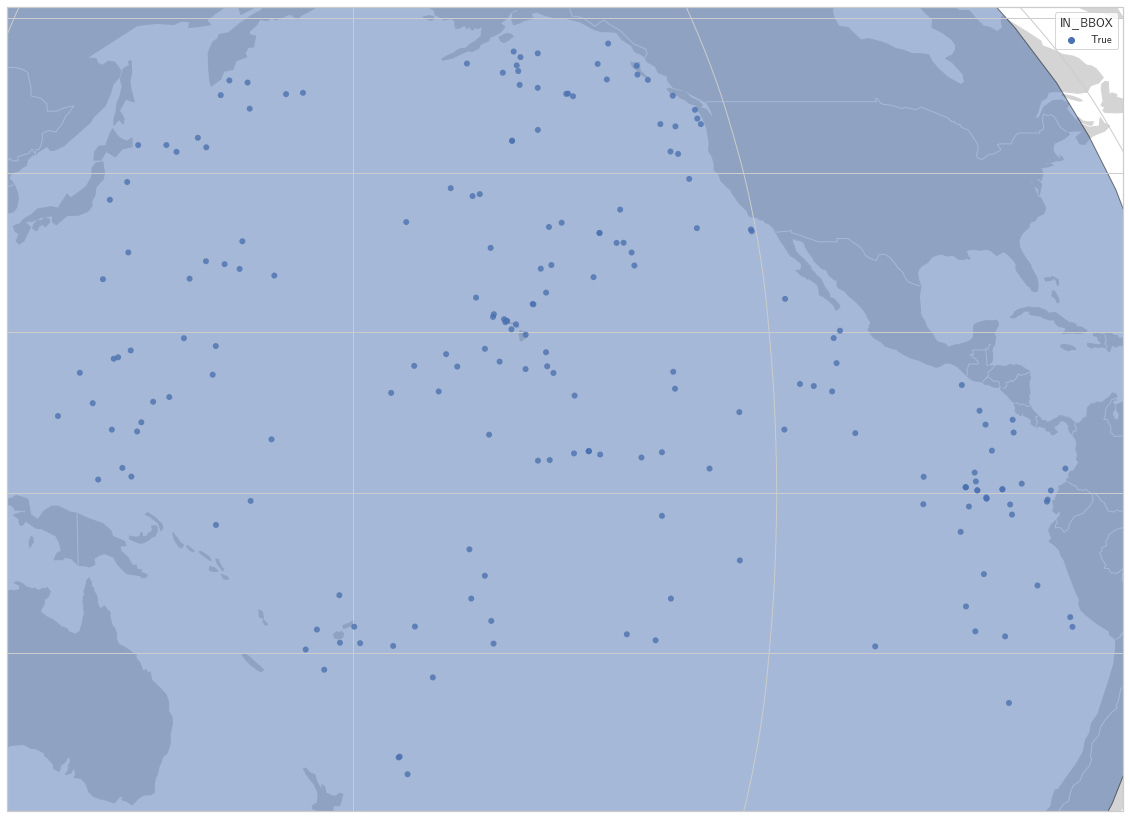

In [32]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': cartopy.crs.Robinson(central_longitude=180)})

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=1, edgecolor=("#FFFFFF"))

ax.add_feature(cartopy.feature.LAND, facecolor=("#d4d4d4"))
ax.gridlines()

sns.scatterplot(ax=ax, data=all_locations, transform=ccrs.PlateCarree(), y="LATITUDE", x="LONGITUDE", zorder=10, linewidth=0, alpha=0.8, hue="IN_BBOX")
ax.add_geometries([bbox_polygon_new], crs=ccrs.PlateCarree(), facecolor = 'b', edgecolor='black', alpha=0.5)

plt.show()